##### Building a hybrid anomaly detection model combining a sparse autoencoder, Isolation Forest, and SVM begins by loading and cleaning your data. Select key features and split the data into training and testing sets. Normalize the data through feature scaling, which is crucial for the model's accuracy. First, use a sparse autoencoder for dimensionality reduction, making the data more manageable and focused. Then, apply an Isolation Forest to efficiently identify potential outliers, followed by an SVM to refine, and confirm the detection of anomalies with precise boundaries. Evaluate the model's effectiveness using precision, recall, the F1-score, and a confusion matrix. This sequential approach harnesses the strengths of each model component, ensuring comprehensive and effective anomaly detection.

In [24]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.ensemble import IsolationForest

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report, confusion_matrix

Epoch 1/50
78/78 [==============================] - 0s 1ms/step - loss: 58282.3867
Epoch 2/50
78/78 [==============================] - 0s 1ms/step - loss: 58268.3047
Epoch 3/50
78/78 [==============================] - 0s 1ms/step - loss: 58268.2852
Epoch 4/50
78/78 [==============================] - 0s 1ms/step - loss: 58268.2930
Epoch 5/50
78/78 [==============================] - 0s 1ms/step - loss: 58268.2773
Epoch 6/50
78/78 [==============================] - 0s 1ms/step - loss: 58268.2969
Epoch 7/50
78/78 [==============================] - 0s 1ms/step - loss: 58268.2852
Epoch 8/50
78/78 [==============================] - 0s 1ms/step - loss: 58268.2969
Epoch 9/50
78/78 [==============================] - 0s 1ms/step - loss: 58268.2930
Epoch 10/50
78/78 [==============================] - 0s 1ms/step - loss: 58268.2969
Epoch 11/50
78/78 [==============================] - 0s 1ms/step - loss: 58268.3047
Epoch 12/50
78/78 [==============================] - 0s 1ms/step - loss: 58268.2852
E

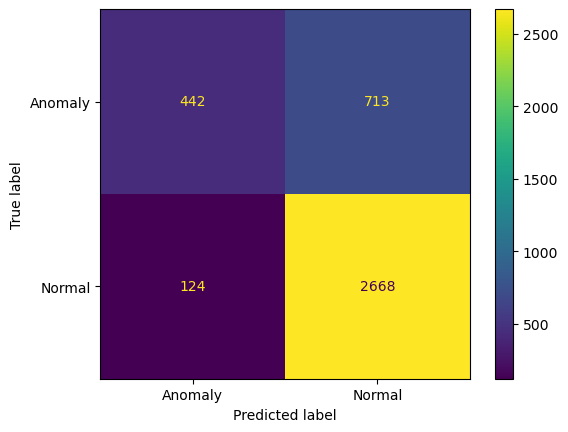

In [25]:

def hybrid_anomaly_detection():

    
        # Load data from a CSV file   
    data = pd.read_csv('energydata.csv')
    
    data = data.drop('date', axis=1)
    
    X = data.drop('Windspeed', axis=1)  # Assuming 'target' is the column name of the continuous target variable
    y_cont = data['Windspeed']
    
    #convert all the values in the columns into numeric
    for column in data.columns:
        data[column] = pd.to_numeric(data[column], errors='coerce')

    
    
    y = np.where(y_cont > 2, 1, 0)  # Define `threshold` based on the dataset
    
        
    # Select top k features; you might adjust k based on your dataset
    selector = SelectKBest(f_classif, k=10)
    X_selected = selector.fit_transform(X, y)
    
    data.dropna(axis=0, inplace=True)
    
    
    
    # Build and train sparse autoencoder
    input_dim = X_selected.shape[1]
    encoding_dim = 32
    input_layer = Input(shape=(input_dim,))
    encoder = Dense(encoding_dim, activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_layer)
    decoder = Dense(input_dim, activation='sigmoid')(encoder)
    autoencoder = Model(inputs=input_layer, outputs=decoder)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    autoencoder.fit(X_selected, X_selected, epochs=50, batch_size=256, shuffle=True)
    
    # Encode the data
    encoder_model = Model(inputs=autoencoder.input, outputs=autoencoder.layers[1].output)
    X_encoded = encoder_model.predict(X_selected)
    
    # Split the data into train and test after encoding
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
    
    # Scale the features after splitting
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    
    
    # Train Isolation Forest on the encoded data
    iso_forest = IsolationForest(random_state=42)
    iso_forest.fit(X_train_scaled)
    if_train_labels = iso_forest.predict(X_train_scaled)
    
    # Filter only rows detected as normal
    normal_indices = if_train_labels == 1
    X_train_normal = X_train_scaled[normal_indices]
    y_train_normal = y_train[normal_indices]
    
    # Train SVM on the filtered normal data
    svm = SVC(kernel='rbf', gamma='auto', random_state=42)
    svm.fit(X_train_normal, y_train_normal)
    
    # Predict on the entire test dataset
    svm_predictions = svm.predict(X_test_scaled)
    
    # Evaluate the model
    precision = precision_score(y_test, svm_predictions, pos_label=1)
    recall = recall_score(y_test, svm_predictions, pos_label=1)
    f1 = f1_score(y_test, svm_predictions, pos_label=1)
    
    
    print(classification_report(y_test, svm_predictions))
    
        # Print metrics
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, svm_predictions, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Anomaly', 'Normal'])
    disp.plot()
    plt.show()
    
    
    
    
    
    
#     # Use Isolation Forest
#     iso = IsolationForest(contamination=0.1, random_state=42)
#     iso.fit(X_train_scaled)
#     iso_preds = iso.predict(X_train_scaled)
    
#     # Use the outcome that is identified as normal only
#     normal_data_indices = np.where(iso_preds == 1)[0]
#     normal_data = X_train_scaled[normal_data_indices]
#     normal_labels = y_train[normal_data_indices]
    
#     # Train a new Isolation Forest on the normal data
#     iso2 = IsolationForest(contamination=0.1, random_state=42)
#     iso2.fit(normal_data)
    
#     # Fit the SVM on the output of the second Isolation Forest
#     svm = SVC(kernel='rbf')
#     svm.fit(normal_data, normal_labels)
    
#     # Predict on the test data
#     svm_preds = svm.predict(X_test_scaled)
    
#     # Use Isolation Forest to identify normal data points
#     iso_forest = IsolationForest(contamination=0.1, n_estimators=100, random_state=42)
#     iso_forest.fit(X_train_scaled)
#     iso_preds = iso_forest.predict(X_train_scaled)
#     normal_indices = np.where(iso_preds == 1)[0]
    
    
#     # Enhance the dataset with SVM outcomes
#     X_train_enhanced = np.hstack((X_train, svm_predictions_train.reshape(-1, 1)))
#     X_test_enhanced = np.hstack((X_test, svm_predictions_test.reshape(-1, 1)))

#     # Filter only rows SVM detected as normal (label '1')
#     normal_indices_train = svm_predictions_train == 1
#     X_train_filtered = X_train_enhanced[normal_indices_train]
#     y_train_filtered = y_train[normal_indices_train]
    
    
    
#     # Use the filtered data by normal values to fit the SVM
#     X_train_normal = X_train_scaled[normal_indices]
#     y_train_normal = y_train.iloc[normal_indices]
#     svm = SVC(kernel='rbf')
#     svm.fit(X_train_normal, y_train_normal)
    
#     # Predict and evaluate the model
#     y_pred = svm.predict(X_test_scaled)
#     precision = precision_score(y_test, y_pred, average='weighted')
#     recall = recall_score(y_test, y_pred, average='weighted')
#     f1 = f1_score(y_test, y_pred, average='weighted')
    
    
#     print(f'Precision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1:.3f}')
    
#     print(classification_report(y_test, svm_preds))
    
#     # Visualize the outcome with a confusion matrix
    
#     # Display the confusion matrix
#     cm = confusion_matrix(y_test, svm_preds, labels=[0, 1])
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Anomaly', 'Normal'])
#     disp.plot()
#     plt.show()
    
    
    
#     cm = confusion_matrix(y_test, y_pred)
#     plt.figure(figsize=(8, 6))
#     plt.imshow(cm, cmap='Blues', interpolation='nearest')
#     plt.title('Confusion Matrix')
#     plt.colorbar()
#     plt.xticks(np.arange(len(np.unique(y_test))), np.unique(y_test))
#     plt.yticks(np.arange(len(np.unique(y_test))), np.unique(y_test))
#     plt.xlabel('Predicted labels')
#     plt.ylabel('True labels')
#     plt.show()

# Example usage

hybrid_anomaly_detection()